In [1]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [4]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [5]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [8]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [9]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [10]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [11]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for data in train_dataset:
      unique_labels = np.unique(data['labels'].cpu())
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [12]:
mul_factor =  5 #increases the total # of ims in a batch
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
val_sampler = WeightedRandomSampler(get_balanced_weights(val_dataset), len(val_dataset) * mul_factor)

In [13]:
len(train_sampler.weights), len(val_sampler.weights)

(4953, 4953)

In [14]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight']
Y

device(type='cuda', index=0)

In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [16]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze()

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-weighted-dice-aug-adam-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=16)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='multiclass')
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:07<00:00,  2.02s/it]


Epoch: 1, Loss: 0.47437520072980754


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.24it/s]


Validation: Loss: 0.274569 | F1-Score: 56.62% | IoU: 39.60% | Precision: 47.89% | Recall: 69.56% | Accuracy: 97.87%
Model saved at 1 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:05<00:00,  2.02s/it]


Epoch: 2, Loss: 0.3429284246315944


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.272610 | F1-Score: 56.35% | IoU: 39.38% | Precision: 49.14% | Recall: 66.55% | Accuracy: 97.98%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:15<00:00,  2.03s/it]


Epoch: 3, Loss: 0.3102208790236973


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.22it/s]


Validation: Loss: 0.261153 | F1-Score: 58.41% | IoU: 41.35% | Precision: 52.35% | Recall: 66.67% | Accuracy: 98.13%
Model saved at 3 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:12<00:00,  2.02s/it]


Epoch: 4, Loss: 0.288672996439444


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.22it/s]


Validation: Loss: 0.257194 | F1-Score: 59.53% | IoU: 42.54% | Precision: 55.98% | Recall: 64.16% | Accuracy: 98.21%
Model saved at 4 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:08<00:00,  2.02s/it]


Epoch: 5, Loss: 0.2722177558340306


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.22it/s]


Validation: Loss: 0.245156 | F1-Score: 60.84% | IoU: 43.90% | Precision: 54.43% | Recall: 69.15% | Accuracy: 98.08%
Model saved at 5 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:02<00:00,  2.02s/it]


Epoch: 6, Loss: 0.2591392184951817


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.23it/s]


Validation: Loss: 0.241160 | F1-Score: 61.69% | IoU: 44.75% | Precision: 56.87% | Recall: 67.67% | Accuracy: 98.27%
Model saved at 6 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:04<00:00,  2.02s/it]


Epoch: 7, Loss: 0.2507634929041992


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.24it/s]


Validation: Loss: 0.232247 | F1-Score: 63.50% | IoU: 46.56% | Precision: 59.63% | Recall: 68.11% | Accuracy: 98.32%
Model saved at 7 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:16<00:00,  2.03s/it]


Epoch: 8, Loss: 0.24281885804131972


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.23it/s]


Validation: Loss: 0.235987 | F1-Score: 62.91% | IoU: 45.93% | Precision: 58.53% | Recall: 68.18% | Accuracy: 98.35%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:18<00:00,  2.03s/it]


Epoch: 9, Loss: 0.23795708063845486


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.22it/s]


Validation: Loss: 0.235766 | F1-Score: 62.97% | IoU: 46.07% | Precision: 58.37% | Recall: 68.44% | Accuracy: 98.28%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:04<00:00,  2.02s/it]


Epoch: 10, Loss: 0.23266028617665133


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.11it/s]


Validation: Loss: 0.242083 | F1-Score: 62.03% | IoU: 45.07% | Precision: 58.06% | Recall: 66.79% | Accuracy: 98.32%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:02<00:00,  2.02s/it]


Epoch: 11, Loss: 0.22714247814444607


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.23it/s]


Validation: Loss: 0.230525 | F1-Score: 63.50% | IoU: 46.60% | Precision: 58.72% | Recall: 69.41% | Accuracy: 98.37%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:02<00:00,  2.02s/it]


Epoch: 12, Loss: 0.22269683678752383


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:12<00:00,  1.23it/s]


Validation: Loss: 0.251754 | F1-Score: 59.07% | IoU: 42.23% | Precision: 55.39% | Recall: 64.47% | Accuracy: 98.35%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [52:04<00:00,  2.02s/it]


Epoch: 13, Loss: 0.2200323383225181


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.234700 | F1-Score: 62.80% | IoU: 45.86% | Precision: 58.77% | Recall: 67.57% | Accuracy: 98.29%


  0%|                                                                               | 2/1548 [00:06<1:22:39,  3.21s/it]


KeyboardInterrupt: 

In [21]:
best_model = torch.load('model-weighted-dice-aug-adam-2024-06-22.pt')
best_model = best_model.to(device)

In [22]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:32<00:00,  1.37it/s]


In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.630811,0.460719,0.610829,0.652145
2,0.647252,0.478472,0.576076,0.738496
3,0.656260,0.488384,0.627524,0.687754
4,0.678380,0.513294,0.626714,0.739331
5,0.632419,0.462436,0.574270,0.703670


In [24]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 64.90%
IoU: 48.07%
Precision: 60.31%
Recall: 70.43%
Overall Accuracy: 98.33%


In [25]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

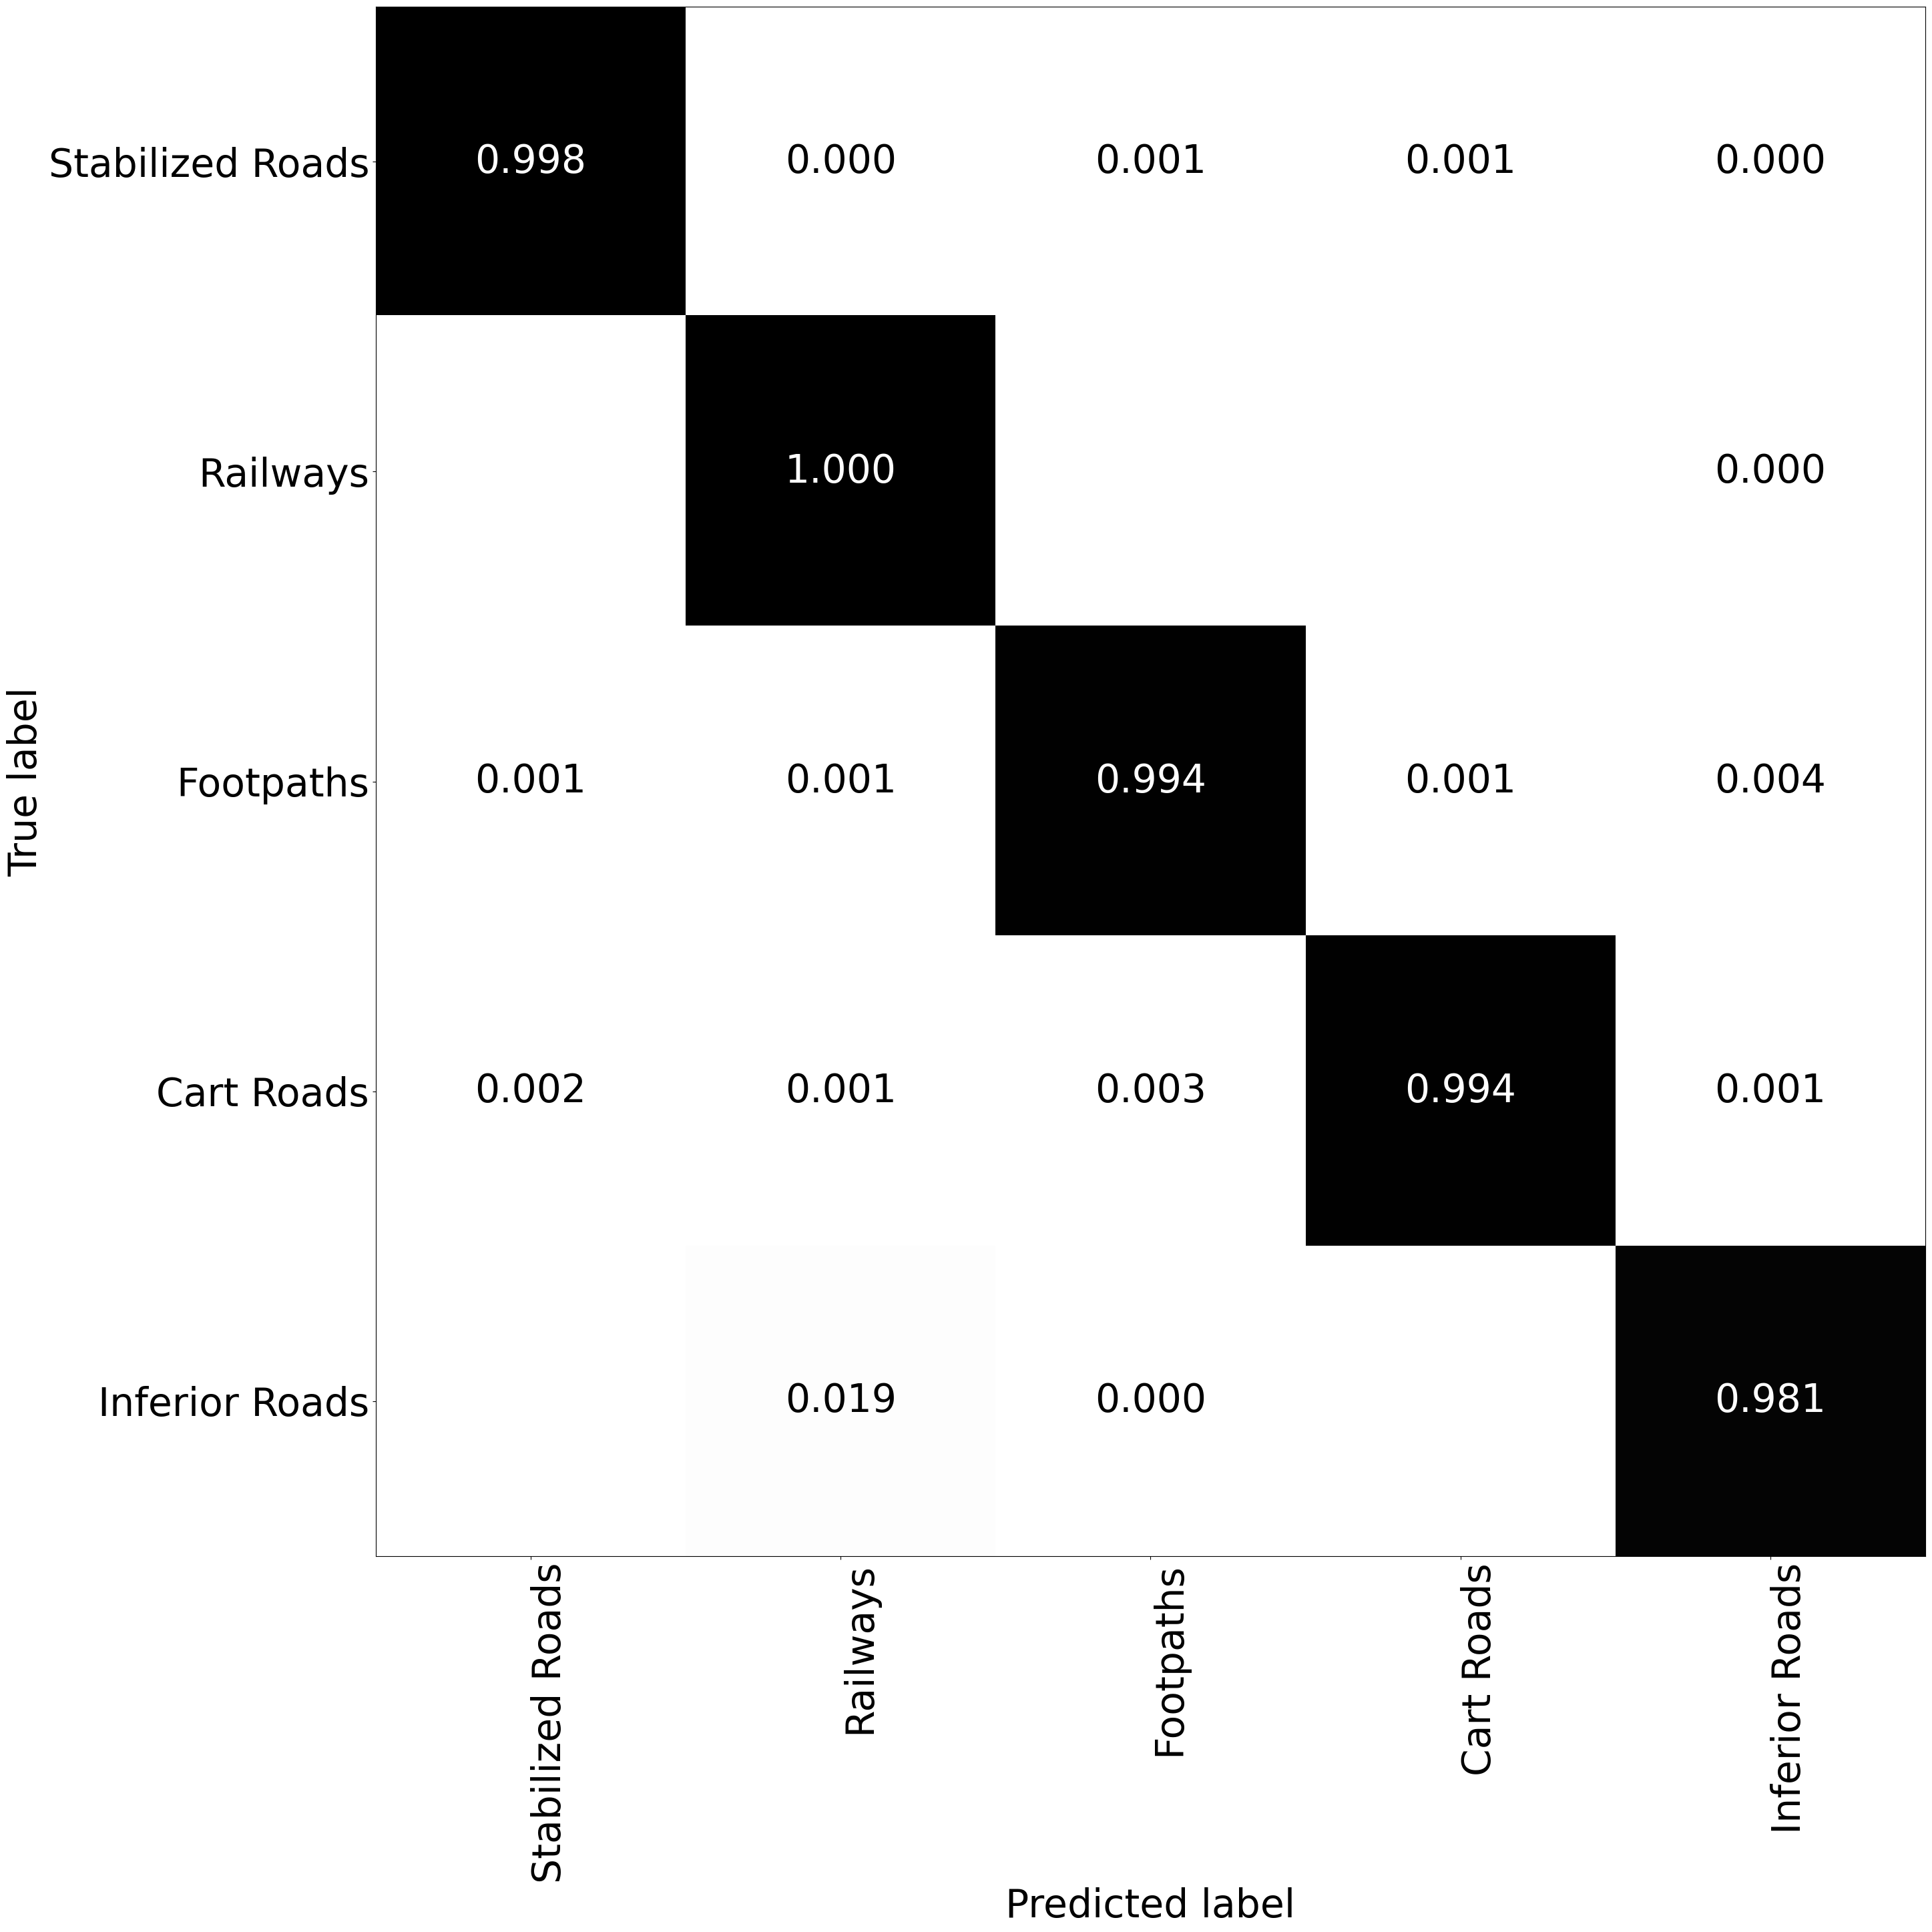

In [27]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [39]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


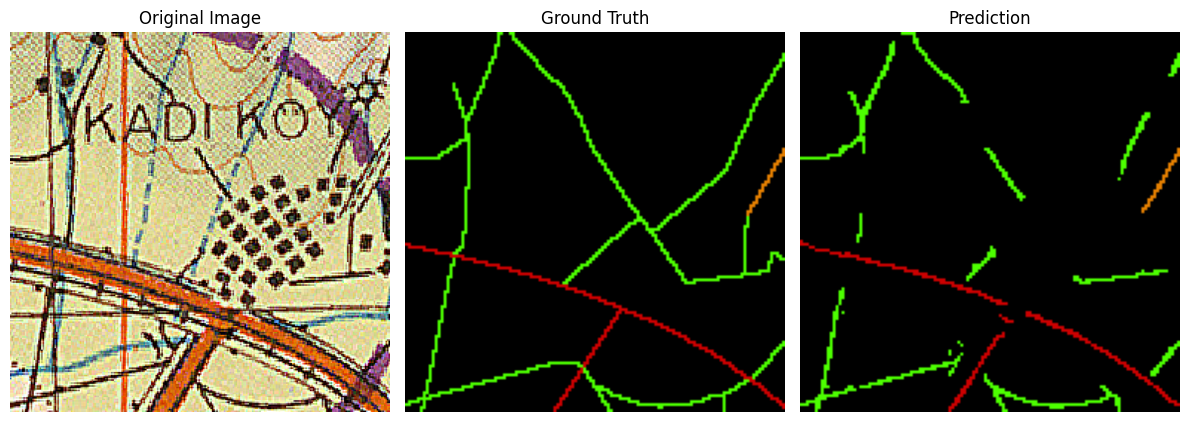

In [40]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
